In [5]:
import pandas as pd
import random
import sklearn
from sklearn.utils import shuffle

#df = pandas.read_csv("/Users/harshsharan/Downloads/archive/ddos_balanced/final_dataset.csv")
#n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
#s = 3000 #desired sample size
#skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
#df = pandas.read_csv(filename, skiprows=skip)

In [71]:
from pandas import concat
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7568347 entries, 0 to 7616508
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Flow ID            object 
 2   Src IP             object 
 3   Src Port           int64  
 4   Dst IP             object 
 5   Dst Port           int64  
 6   Protocol           int64  
 7   Timestamp          object 
 8   Flow Duration      int64  
 9   Tot Fwd Pkts       int64  
 10  Tot Bwd Pkts       int64  
 11  TotLen Fwd Pkts    float64
 12  TotLen Bwd Pkts    float64
 13  Fwd Pkt Len Max    float64
 14  Fwd Pkt Len Min    float64
 15  Fwd Pkt Len Mean   float64
 16  Fwd Pkt Len Std    float64
 17  Bwd Pkt Len Max    float64
 18  Bwd Pkt Len Min    float64
 19  Bwd Pkt Len Mean   float64
 20  Bwd Pkt Len Std    float64
 21  Flow Byts/s        float64
 22  Flow Pkts/s        float64
 23  Flow IAT Mean      float64
 24  Flow IAT Std       float64
 25  Flow IAT Max      

In [44]:
mb = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(mb))

Memory usage of dataframe is 4939.30 MB


In [45]:
import gc
import numpy as np
colsToDrop = np.array(['Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg'])
gc.collect()

8658

In [46]:
import pandas as pd
from sklearn import preprocessing

In [47]:
# counting unique values and checking for skewness in the data
rowbuilder = lambda col: {'col': col, 'unique_values': df[col].nunique(), 'most_frequent_value': df[col].value_counts().index[0],'frequency': df[col].value_counts(normalize=True).values[0]}
frequency = [rowbuilder(col) for col in df.select_dtypes(include=['category']).columns]
skewed = pd.DataFrame(frequency)
colsToDrop
del skewed
del rowbuilder
del frequency
gc.collect()

0

In [48]:
missing = df.isna().sum()
missing = pd.DataFrame({'count': missing, '% of total': missing/len(df)*100}, index=df.columns)
colsToDrop = np.union1d(colsToDrop, missing[missing['% of total'] >= 50].index.values)
dropnaCols = missing[(missing['% of total'] > 0) & (missing['% of total'] <= 5)].index.values

In [49]:
df['Flow Byts/s'].replace(np.inf, np.nan, inplace=True)
df['Flow Pkts/s'].replace(np.inf, np.nan, inplace=True)
dropnaCols = np.union1d(dropnaCols, ['Flow Byts/s', 'Flow Pkts/s'])

In [50]:
colsToDrop


array(['Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
       'Fwd Blk Rate Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg'],
      dtype=object)

In [51]:
df.drop(columns=colsToDrop, inplace=True)
df.dropna(subset=dropnaCols, inplace=True)
gc.collect()

101

In [52]:
negValCols = ['Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min']
for col in negValCols:
    df = df[df[col] >= 0]

In [53]:
mb = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(mb))

Memory usage of dataframe is 4619.35 MB


In [67]:
df['Label'].value_counts()
#df_B = df.loc[df.Label == "Benign"]
df_B.info

<bound method DataFrame.info of          Unnamed: 0                                   Flow ID          Src IP  \
1294529     1445871       172.31.0.2-172.31.66.76-53-55330-17    172.31.66.76   
1294530      283411   172.217.9.228-192.168.10.15-443-53799-6   192.168.10.15   
1294531     6626404  129.158.72.21-172.31.66.121-56889-3389-6   129.158.72.21   
1294532     6314547    172.31.65.117-23.218.55.94-51263-443-6   172.31.65.117   
1294533     7887478    172.31.67.95-94.25.169.113-445-35818-6   94.25.169.113   
...             ...                                       ...             ...   
7616504     1725894    172.31.67.50-209.85.203.113-53598-80-6  209.85.203.113   
7616505     5681778    172.31.69.17-108.174.10.14-54599-443-6    172.31.69.17   
7616506     6395326       172.31.0.2-172.31.65.49-53-61087-17    172.31.65.49   
7616507     4926899       172.31.0.2-172.31.67.58-53-61580-17    172.31.67.58   
7616508     7656685   169.254.169.254-172.31.65.89-80-49393-6    172.31.65.89

In [68]:
#df_Dd = df.loc[df.Label == "ddos"]
df_Dd.info

<bound method DataFrame.info of          Unnamed: 0                                 Flow ID          Src IP  \
0           1739476   172.31.69.25-18.219.193.20-80-37882-6   18.219.193.20   
1           1822666      172.31.69.28-18.219.9.1-80-63287-6    172.31.69.28   
2            905739   172.31.69.28-52.14.136.135-80-63095-6   52.14.136.135   
3           1143064  172.31.69.28-18.216.200.189-80-52341-6  18.216.200.189   
4           1934016   172.31.69.28-18.218.55.126-80-57459-6    172.31.69.28   
...             ...                                     ...             ...   
1294524     1375925   172.31.69.25-18.219.193.20-80-46098-6   18.219.193.20   
1294525      467036   172.31.69.25-18.219.193.20-80-37126-6   18.219.193.20   
1294526     1535528   172.31.69.28-18.218.55.126-80-50384-6    172.31.69.28   
1294527     1830374   172.31.69.28-18.218.55.126-80-63497-6    172.31.69.28   
1294528     1383974    172.31.69.28-18.219.32.43-80-52066-6    172.31.69.28   

         Src Port  

In [80]:
#first_s1 = df_B.sample(300000, random_state=10)
#first_s2= df_Dd.sample(300000, random_state=10)
#first_s = pd.concat([first_s1,first_s2])
first_s.describe
first_s.to_csv('first_split.csv')

In [81]:
#second_s1 = df_B.sample(300000, random_state=30)
#second_s2= df_Dd.sample(300000, random_state=30)
#second_s = pd.concat([second_s1,second_s2])
second_s.describe
second_s.to_csv('second_split.csv')

In [82]:
#third_s1 = df_B.sample(300000, random_state=40)
#third_s2= df_Dd.sample(300000, random_state=40)
#third_s = pd.concat([third_s1,third_s2])
third_s.describe
third_s.to_csv('third_split.csv')

In [83]:
#fourth_s1 = df_B.sample(300000, random_state=50)
#fourth_s2= df_Dd.sample(300000, random_state=50)
#fourth_s = pd.concat([fourth_s1,fourth_s2])
fourth_s.describe
fourth_s.to_csv('fourth_split.csv')

In [4]:
data = pd.read_csv("second_split.csv")

In [6]:
df = shuffle(data)

In [7]:
df.to_csv('shuffled_data.csv')

In [9]:
data_s = pd.read_csv("shuffled_data.csv")

In [13]:
data_s.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Flow ID', 'Src IP',
       'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp',
       'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'In

In [14]:
y=df['Label']

In [15]:
#y=y.replace(to_replace=['ddos', 'Benign'], value=[0, 1])

In [16]:
del df['Label']
del df['Unnamed: 0']
#label encoding for object types
#le = preprocessing.LabelEncoder()
#df['Flow ID','Src IP','Dst IP','Timestamp'] = le.fit_transfrom(df[['Flow ID','Src IP','Dst IP','Timestamp'].astype(str)])

In [17]:
#label encoding for object types
le = preprocessing.LabelEncoder()
#df['Flow ID','Src IP','Dst IP','Timestamp'] = le.fit_transform(df['Flow ID','Src IP','Dst IP','Timestamp'].astype(str))
df['Flow ID'] = le.fit_transform(df['Flow ID'].astype(str))
df['Src IP'] = le.fit_transform(df['Src IP'].astype(str))
df['Dst IP'] = le.fit_transform(df['Dst IP'].astype(str))
df['Timestamp'] = le.fit_transform(df['Timestamp'].astype(str))
y = le.fit_transform(y.astype(str))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2978 entries, 0 to 2999
Data columns (total 77 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            2978 non-null   int64  
 1   Src IP             2978 non-null   int64  
 2   Src Port           2978 non-null   int64  
 3   Dst IP             2978 non-null   int64  
 4   Dst Port           2978 non-null   int64  
 5   Protocol           2978 non-null   int64  
 6   Timestamp          2978 non-null   int64  
 7   Flow Duration      2978 non-null   int64  
 8   Tot Fwd Pkts       2978 non-null   int64  
 9   Tot Bwd Pkts       2978 non-null   int64  
 10  TotLen Fwd Pkts    2978 non-null   float64
 11  TotLen Bwd Pkts    2978 non-null   float64
 12  Fwd Pkt Len Max    2978 non-null   float64
 13  Fwd Pkt Len Min    2978 non-null   float64
 14  Fwd Pkt Len Mean   2978 non-null   float64
 15  Fwd Pkt Len Std    2978 non-null   float64
 16  Bwd Pkt Len Max    2978 

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

In [20]:
#df['Flow Byts/s'].replace(np.inf, np.nan, inplace=True)
#df['Flow Pkts/s'].replace(np.inf, np.nan, inplace=True)
#dropnaCols = np.union1d(dropnaCols, ['Flow Byts/s', 'Flow Pkts/s'])

In [21]:
#df = df.applymap(str)
#encoder = OrdinalEncoder()
# transform data
#result = encoder.fit_transform(df)
#print(result)

In [22]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_scaled_data = sc.fit_transform(df)

In [23]:
from sklearn.model_selection import train_test_split
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_data, y,test_size = 0.3, random_state=69)   #scale the test data as well
#Train Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=69)

In [259]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(2434, 77)
(1491, 77)
(2434,)
(1491,)
(1044, 77)
(1044,)


In [260]:
print(X_scaled_data.shape)
print(y.shape)

(4969, 77)
(4969,)


In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [25]:
model = Sequential()
model.add(Dense(300, input_dim=77, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(150, activation='softmax'))
#model.add(Dropout(0.2))
model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               23400     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 68,701
Trainable params: 68,701
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.utils import np_utils
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.002),
              metrics=['accuracy'])
hist=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
46/46 [==============================] - 1s 6ms/step - loss: 0.0109 - accuracy: 0.9983 - val_loss: 0.0219 - val_accuracy: 0.9968
Epoch 2/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.0213 - val_accuracy: 0.9968
Epoch 3/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.0176 - val_accuracy: 0.9984
Epoch 4/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 0.0198 - val_accuracy: 0.9968
Epoch 5/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 0.9957 - val_loss: 0.0204 - val_accuracy: 0.9968
Epoch 6/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.0840 - val_accuracy: 0.9617
Epoch 7/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0157 - accuracy: 0.9935 - val_loss: 0.0203 - val_accuracy: 0.9968
Epoch 8/20
46/46 [==

In [292]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# #Print out the statistics from the classifier
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# t = f.suptitle('Performance Graph', fontsize=14)
# f.subplots_adjust(top=0.85, wspace=0.3)
# #Plotting accuracy Statistics according to epoch
# epoch_list = list(range(1,101))
# ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
# ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
# ax1.set_xticks(np.arange(0, 101, 5))
# ax1.set_ylabel('Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.set_title('Accuracy Graph')
# l1 = ax1.legend(loc="best")

# ax2.plot(epoch_list, history.history['loss'], label='Training Loss')
# ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
# ax2.set_xticks(np.arange(0, 101, 5))
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Epoch')
# ax2.set_title('Loss Graph')
# l2 = ax2.legend(loc="best")

hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<function matplotlib.pyplot.show(close=None, block=None)>

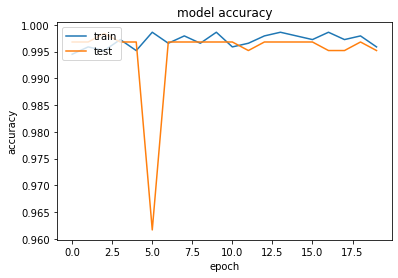

In [37]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

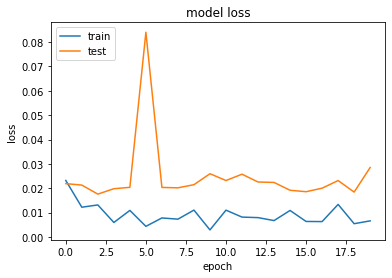

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show

In [31]:
y_pred = model.predict(X_test)

In [32]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

28/28 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9944
[0.03719938173890114, 0.9944071769714355]


In [33]:
print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[744   4]
 [  1 145]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       748
           1       0.97      0.99      0.98       146

    accuracy                           0.99       894
   macro avg       0.99      0.99      0.99       894
weighted avg       0.99      0.99      0.99       894



0.9982785143945498


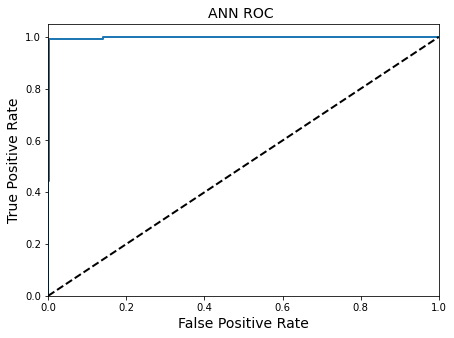

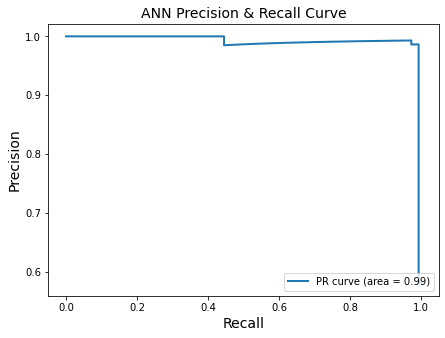

In [39]:
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[7,5])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 2)
plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ANN ROC ', fontsize= 14)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[7,5])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('ANN Precision & Recall Curve', fontsize=14)
plt.legend(loc="lower right")
plt.show()